In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Task 1

In [3]:
data_cache = {}

def load_data(file_path):
    if file_path not in data_cache:
        data_cache[file_path] = pd.read_csv(file_path)

    return data_cache[file_path]

xtest = load_data('Datasets/X_test.csv.gz')
xtrain = load_data('Datasets/X_train.csv.gz')
ytrain = load_data('Datasets/y_train.csv.gz')

In [4]:
def check_missing_data(array):
    np.isnan(array).any()

for name, data in data_cache.items():
    print(f"Observations in {name.split('/')[1]}: {data.shape[0]}")
    print(f"Variables in {name.split('/')[1]}: {data.shape[1]}")

    print(
        "Is table missing any data? " + 
        ("Yes" if check_missing_data(data) else "No")
    )

print('')
print(xtrain.head())
print(ytrain.head())

Observations in X_test.csv.gz: 670
Variables in X_test.csv.gz: 9000
Is table missing any data? No
Observations in X_train.csv.gz: 3794
Variables in X_train.csv.gz: 9000
Is table missing any data? No
Observations in y_train.csv.gz: 3794
Variables in y_train.csv.gz: 2
Is table missing any data? No

   LINC01409  LINC01128  LINC00115  FAM41C     NOC2L  HES4     ISG15  \
0   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   
1   1.296718        0.0        0.0     0.0  1.296718   0.0  0.000000   
2   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   
3   0.000000        0.0        0.0     0.0  0.000000   0.0  1.488047   
4   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   

   C1orf159  TNFRSF18  TNFRSF4  ...    MT-ND2   MT-ATP8   MT-ATP6    MT-CO3  \
0       0.0       0.0      0.0  ...  2.560797  0.786006  3.504192  3.638454   
1       0.0       0.0      0.0  ...  3.316827  0.000000  3.832409  3.316827   
2       0.0       0.0      0.0  

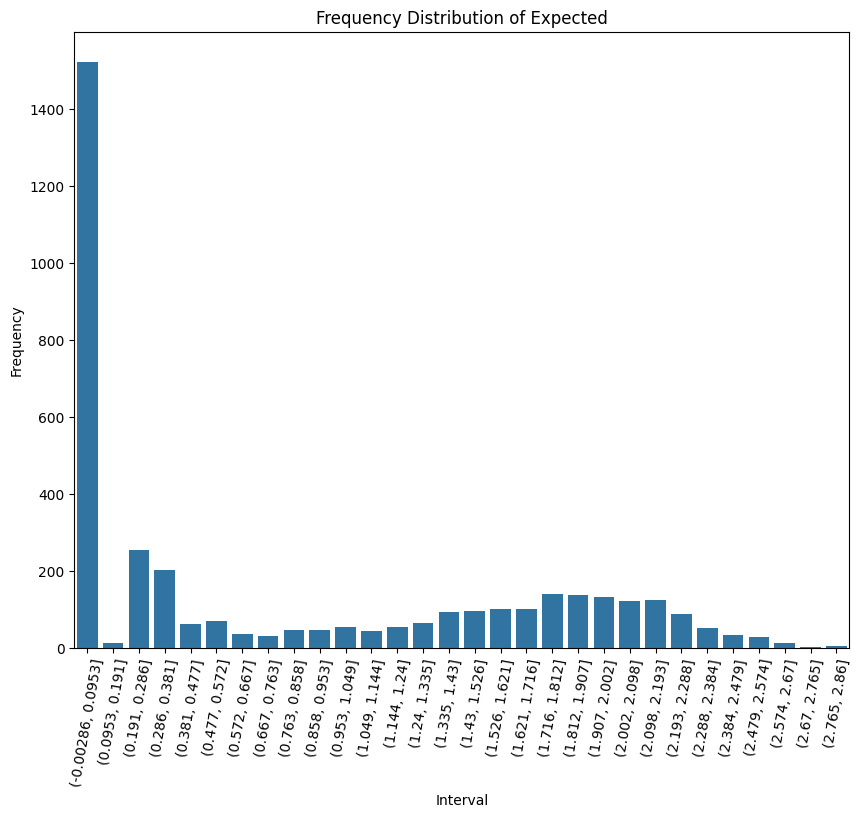

''

In [5]:
def plot_frequency_table(data, variable_name, is_qualitative):
    variable_data = data[variable_name]
    bins = 30
    plt.figure(figsize = (10, 8))

    intervals = pd.cut(variable_data, bins = bins)
    freq_table = intervals.value_counts().reset_index()
    freq_table.columns = ['Interval', 'Frequency']
    freq_table['Percentage'] = freq_table['Frequency'] 
    freq_table['Percentage'] *= 100 / len(variable_data)
    
    freq_table = freq_table.sort_values(by = 'Interval')
    
    sns.barplot(
        x = freq_table['Interval'].astype(str),
        y = freq_table['Frequency'],
    )
    plt.xlabel("Interval")
    
    plt.title(f"Frequency Distribution of {variable_name}")
    plt.ylabel("Frequency")
    # so the intervals fit on the plot
    plt.xticks(rotation = 80)
    plt.show()

    return freq_table

plot_frequency_table(ytrain, 'Expected', False)
''

In [6]:
print(ytrain['Expected'].describe())

print(f'Zero appears {np.sum(ytrain['Expected'] == 0)} times in the provided data.')

print(f'Values below 0.14: {np.sum(ytrain['Expected'] < 0.14)}')

count    3794.000000
mean        0.791096
std         0.860856
min         0.000000
25%         0.000000
50%         0.311748
75%         1.662514
max         2.860416
Name: Expected, dtype: float64
Zero appears 1523 times in the provided data.
Values below 0.14: 1523


There are really many observations that are equal to zero. Then there is a jump and there are no data points between 0 and 0.14. Then the data follows some distribution with 2 distint peaks around 0.25 and 1.8.

In [7]:
from scipy.stats import pearsonr

def add_to_best_idxs(best_idxs, idx, corr, keep_top = 100):
    if len(best_idxs) == 0:
        best_idxs = [(idx, corr)]
    else:
        for i, (_, corr_) in enumerate(best_idxs):
            if np.abs(corr) > np.abs(corr_):
                best_idxs.insert(i, (idx, corr))
                break

    if len(best_idxs) > keep_top:
        best_idxs = best_idxs[:-1]

    return best_idxs

def compare_correlations(confidence = 0.001):

    corrs = np.zeros(xtrain.shape[1])
    best_idxs = []

    for i, col in enumerate(xtrain.columns):
        column = xtrain[col]

        corr, p_value = pearsonr(column, ytrain['Expected'])
        corrs[i] = corr

        if p_value > confidence: 
            best_idxs = add_to_best_idxs(best_idxs, col, corr)

        # print(best_idxs)

    return corrs, best_idxs

corrs, best_idxs = compare_correlations()

In [23]:
def violin_corr_plot(corr_coeffs):

    sns.violinplot(data=corr_coeffs, inner="quartile")

    plt.title("Distribution of Correlation Coefficients")
    plt.xlabel("RNA vs Protein")
    plt.ylabel("Correlation Coefficient")

    # Show the plot
    plt.show()

def plot_heatmap(heatmap, title, mask_ut = True):
    if mask_ut:
        onesl = np.ones_like(heatmap)
        mask = onesl - np.triu(onesl)
        heatmap *= mask

    print(heatmap)
    min, max = np.min(heatmap), np.max(heatmap)

    plt.figure(figsize=(20, 16))  
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(
        heatmap,
        mask = mask == 0 if mask_ut else None,
        cmap = cmap,
        vmax = max,
        vmin = min, 
        center = 0,
        annot = False,  
        square = True,
        linewidths = 0.5,
        cbar_kws = {"shrink": 0.5},
        xticklabels=2,  # Show every 2nd x-axis label
        yticklabels=2,
    )

    fs = 7
    plt.xticks(fontsize = fs)  
    plt.yticks(fontsize = fs)  
    plt.title(title)
    plt.tight_layout()

    plt.show()

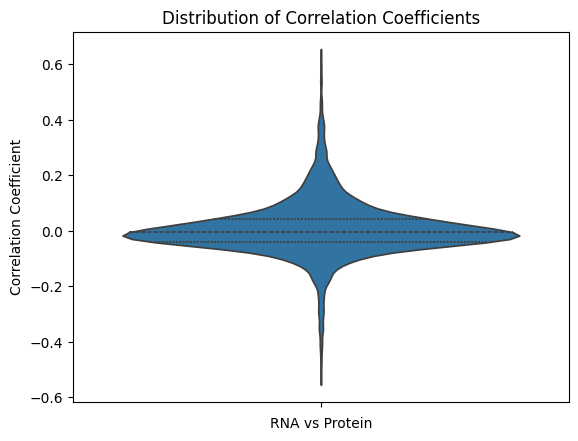

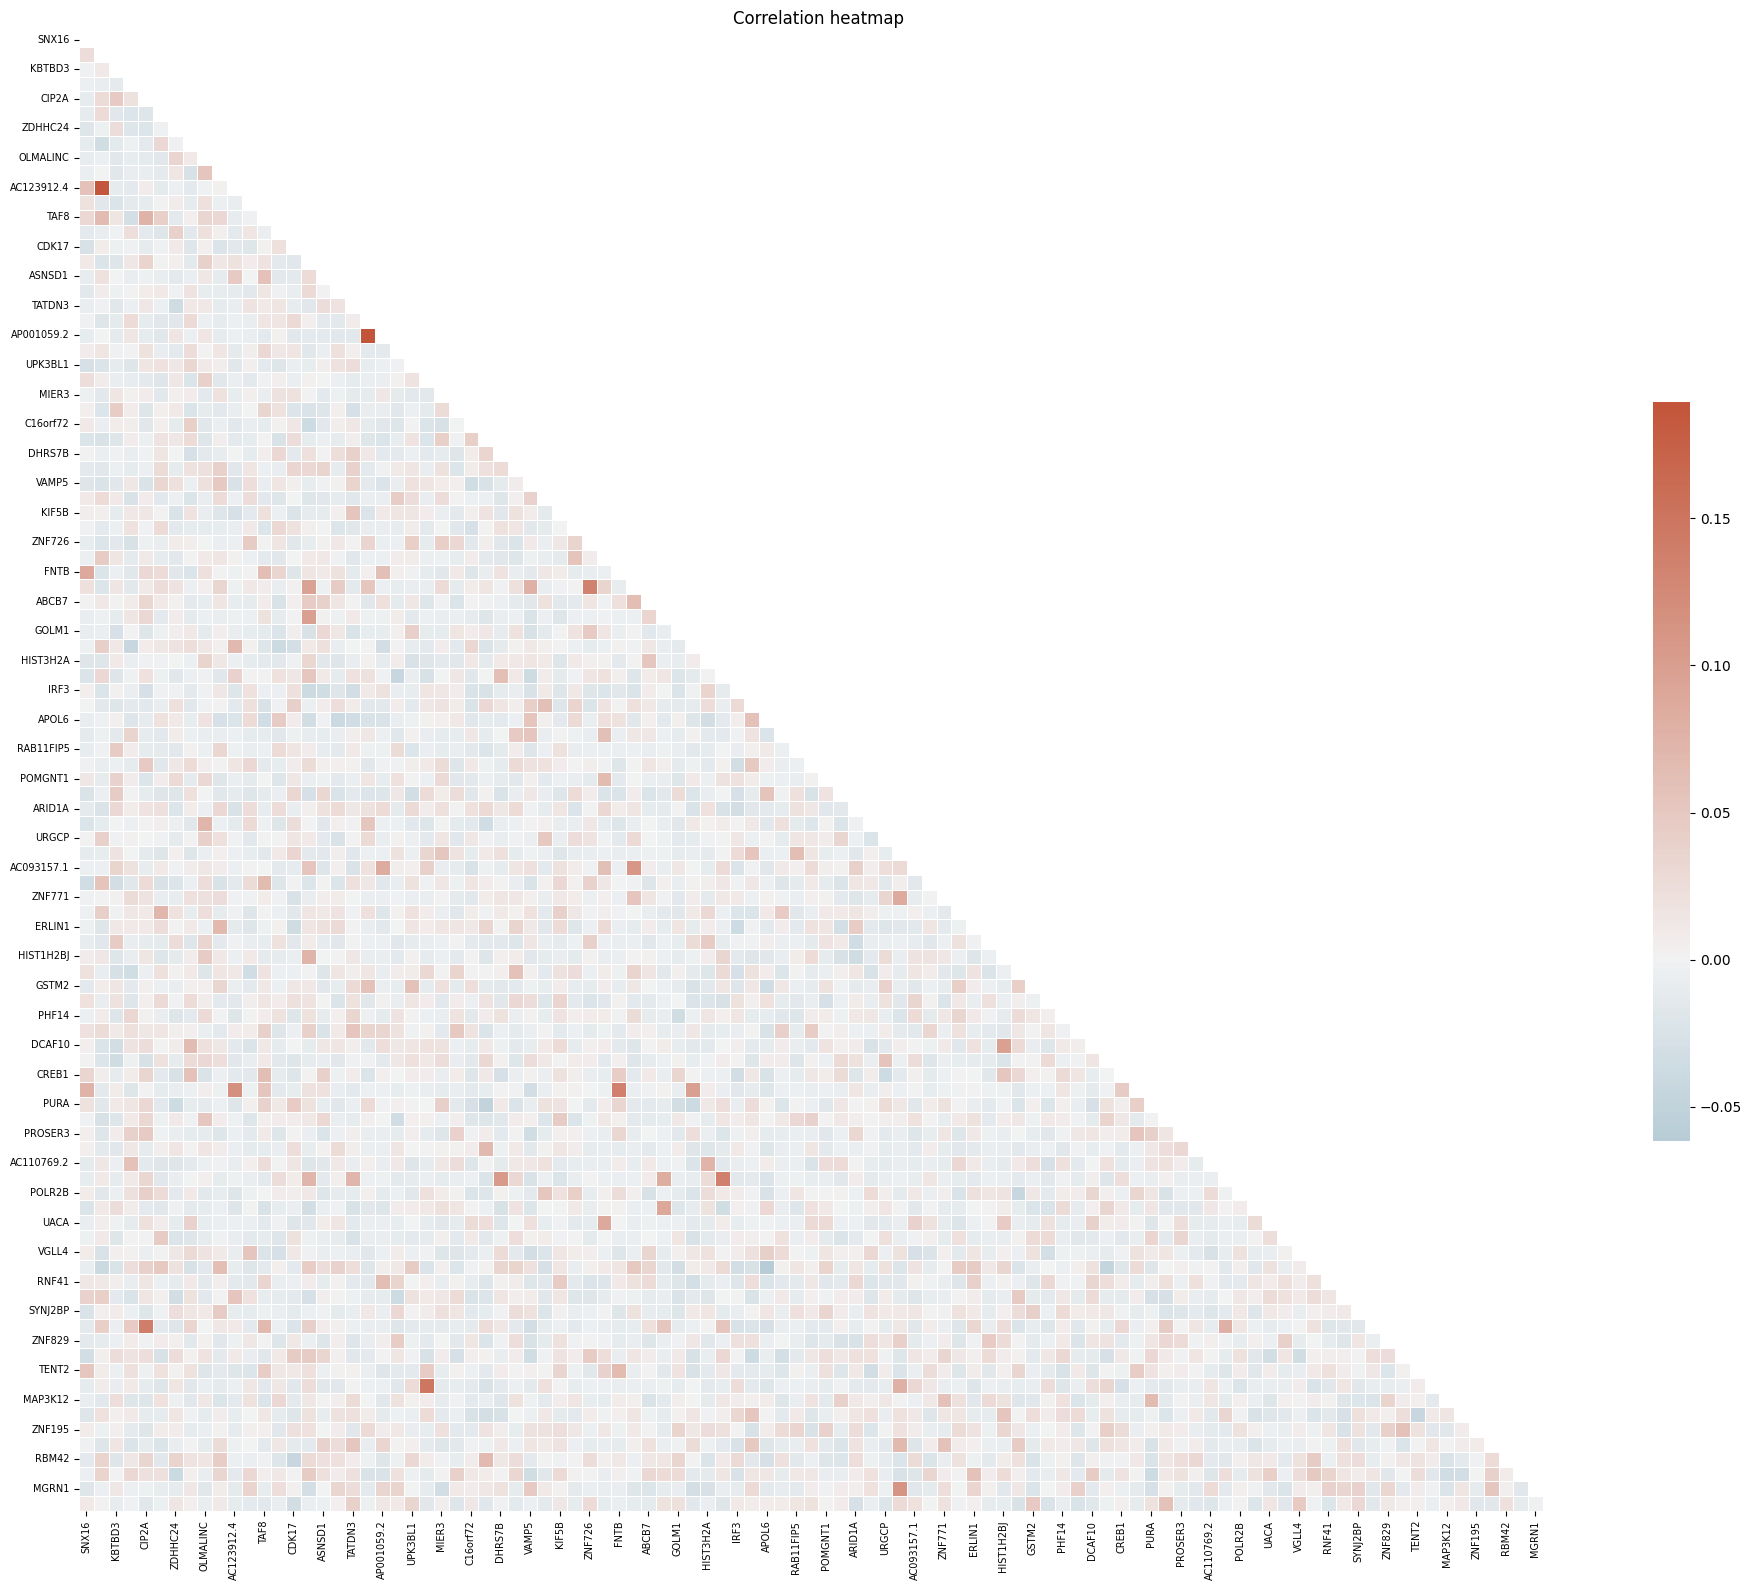

In [22]:
violin_corr_plot(corrs)

best_cols, _ = zip(*best_idxs)
heatmap = xtrain[list(best_cols)].corr()
plot_heatmap(heatmap, title = 'Correlation heatmap')

## Task 2

# ElasticNet Model

ElasticNet is a linear regression model that combines **Lasso Regression** (L1 reg) and **Ridge Regression** (L2 reg). It is effective for datasets with many predictors, especially when some predictors are either irrelevant or highly correlated. L1 regularization facilitates **variable selection** while L2 helps with **regularization** simultaneously, improving model interpretability and preventing overfitting.

---

## Optimization Function

The ElasticNet tries to minimize the following function:

<!-- $$1 / (2 * n\_samples) * ||y - Xw||^2_2 + alpha * l1\_ratio * ||w||_1 + 0.5 * alpha * (1 - l1\_ratio) * ||w||^2_2 $$ -->

$$ \frac{1}{2n} \| y - X\beta \|_2^2 + \alpha \Big[ \lambda \|\beta\|_1 + \frac{1}{2} (1 - \lambda) \|\beta\|_2^2 \Big] $$

_source: scikit-learn.org_

Where:
- y : Target variable.
- X : Input features. 
- $ \beta $ : Model coeffs. 
- $ \|...\|_1 $: L1 norm.
- $ \|...\|_2^2 $: L2 norm.
- $ \alpha $ : Regularization strength. 
- $ \lambda $: L1 ratio. 

---

## Parameters Estimated

1. **Regression coefficients  $ \beta $**
2. **Intercept $ \beta_0 $ :**
    - The constant term. 

---

## Hyperparameters

### 1. $ \alpha $ (Regularization strength):
- Controls the overall strength of regularization.

### 2. $ \lambda $ (L1 ratio):
- Determines the balance between L1 and L2 regularization
- Special case:  **$ \lambda = 1 $:** **Lasso Regression** 
    - Pure L1 regularization.
    - Performs **feature selection** by shrinking some coefficients to exactly zero.
    - Struggles with multicollinearity.
- Special case: **$ \lambda = 0 $:** **Ridge Regression** 
    - Pure L2 regularization.
    - Handles **multicollinearity** by stabilizing correlated coefficients.
    - Does not perform feature selection; all coefficients remain non-zero.

By tuning $ \alpha $ and $ \lambda $ ElasticNet adapts to the specific properties of the dataset.


In [10]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 45

In [11]:
def CV_divide(xs, ys, partitions = 5):
    assert len(xs) == len(ys)
    idxs = np.linspace(0, len(xs), partitions + 1).astype(int)
    idxs = np.vstack([idxs[:-1], idxs[1:]]).T

    for st, fin in idxs:
        xtrain = np.vstack([xs[:st], xs[fin:]])
        ytrain = np.vstack([ys[:st], ys[fin:]])

        xtest = xs[st:fin]
        ytest = ys[st:fin]

        yield (xtrain, ytrain), (xtest, ytest)

In [12]:
def run_ElasticNet(trainset, alpha, l1_ratio, random_state = SEED, partitions = 5):
    error = 0
    X, Y = trainset
    model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state = random_state)
    print(alpha, l1_ratio)

    for train, test in CV_divide(X, Y, partitions = partitions):
        xtrain, ytrain = train
        xtest, ytest = test

        model.fit(xtrain, ytrain)

        y_pred = model.predict(xtest)

        mse = mean_squared_error(ytest, y_pred)
        print(f"Mean Squared Error: {mse:.4f}")

        error += mse

    print('')
    return error / partitions

In [27]:
GRID_SIZE = 5

def CV_run(lamb, alph, xtrain, ytrain):

    lambdas, alphas = np.meshgrid(lamb, alph)

    results = np.zeros((GRID_SIZE, GRID_SIZE))

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            results[i][j] = run_ElasticNet((xtrain, ytrain), alphas[i][j], lambdas[i][j])

    print(np.max(results), np.min(results))

    return results, lambdas, alphas

xt = np.array(xtrain)
yt = np.array(ytrain)[:, 1].reshape(-1, 1)

lambda_arr = np.concat([[0], np.linspace(0.05, 0.2, GRID_SIZE - 2), [1]])
alpha_arr = np.linspace(0.1, 1, GRID_SIZE)

# for clearer output
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

res_tuple = CV_run(lambda_arr, alpha_arr, xt, yt)

0.1 0.0
Mean Squared Error: 0.1275
Mean Squared Error: 0.1191
Mean Squared Error: 0.1341
Mean Squared Error: 0.1367
Mean Squared Error: 0.1142

0.1 0.05
Mean Squared Error: 0.1138
Mean Squared Error: 0.1151
Mean Squared Error: 0.1164
Mean Squared Error: 0.1316
Mean Squared Error: 0.1079

0.1 0.125
Mean Squared Error: 0.1219
Mean Squared Error: 0.1242
Mean Squared Error: 0.1248
Mean Squared Error: 0.1405
Mean Squared Error: 0.1233

0.1 0.2
Mean Squared Error: 0.1298
Mean Squared Error: 0.1320
Mean Squared Error: 0.1341
Mean Squared Error: 0.1480
Mean Squared Error: 0.1351

0.1 1.0
Mean Squared Error: 0.1944
Mean Squared Error: 0.2020
Mean Squared Error: 0.2088
Mean Squared Error: 0.2101
Mean Squared Error: 0.2033

0.325 0.0
Mean Squared Error: 0.1165
Mean Squared Error: 0.1098
Mean Squared Error: 0.1224
Mean Squared Error: 0.1276
Mean Squared Error: 0.1058

0.325 0.05
Mean Squared Error: 0.1329
Mean Squared Error: 0.1337
Mean Squared Error: 0.1367
Mean Squared Error: 0.1477
Mean Squared

Conclusions:

Model doesn't seem to converge when l1_ratio is 0, but it gets the lowest errors in that case. It may be beneficial to look for l1_ratio close to 0.

[[0.         0.         0.         0.         0.        ]
 [0.11642005 0.         0.         0.         0.        ]
 [0.11732301 0.15469409 0.         0.         0.        ]
 [0.11971264 0.17062719 0.2144733  0.         0.        ]
 [0.12246912 0.18431365 0.23853962 0.2880758  0.        ]]
[[0.    0.05  0.125 0.2   1.   ]
 [0.    0.05  0.125 0.2   1.   ]
 [0.    0.05  0.125 0.2   1.   ]
 [0.    0.05  0.125 0.2   1.   ]
 [0.    0.05  0.125 0.2   1.   ]]
[[0.1   0.1   0.1   0.1   0.1  ]
 [0.325 0.325 0.325 0.325 0.325]
 [0.55  0.55  0.55  0.55  0.55 ]
 [0.775 0.775 0.775 0.775 0.775]
 [1.    1.    1.    1.    1.   ]]
[[0.         0.         0.         0.         0.        ]
 [0.11642005 0.         0.         0.         0.        ]
 [0.11732301 0.15469409 0.         0.         0.        ]
 [0.11971264 0.17062719 0.2144733  0.         0.        ]
 [0.12246912 0.18431365 0.23853962 0.2880758  0.        ]]


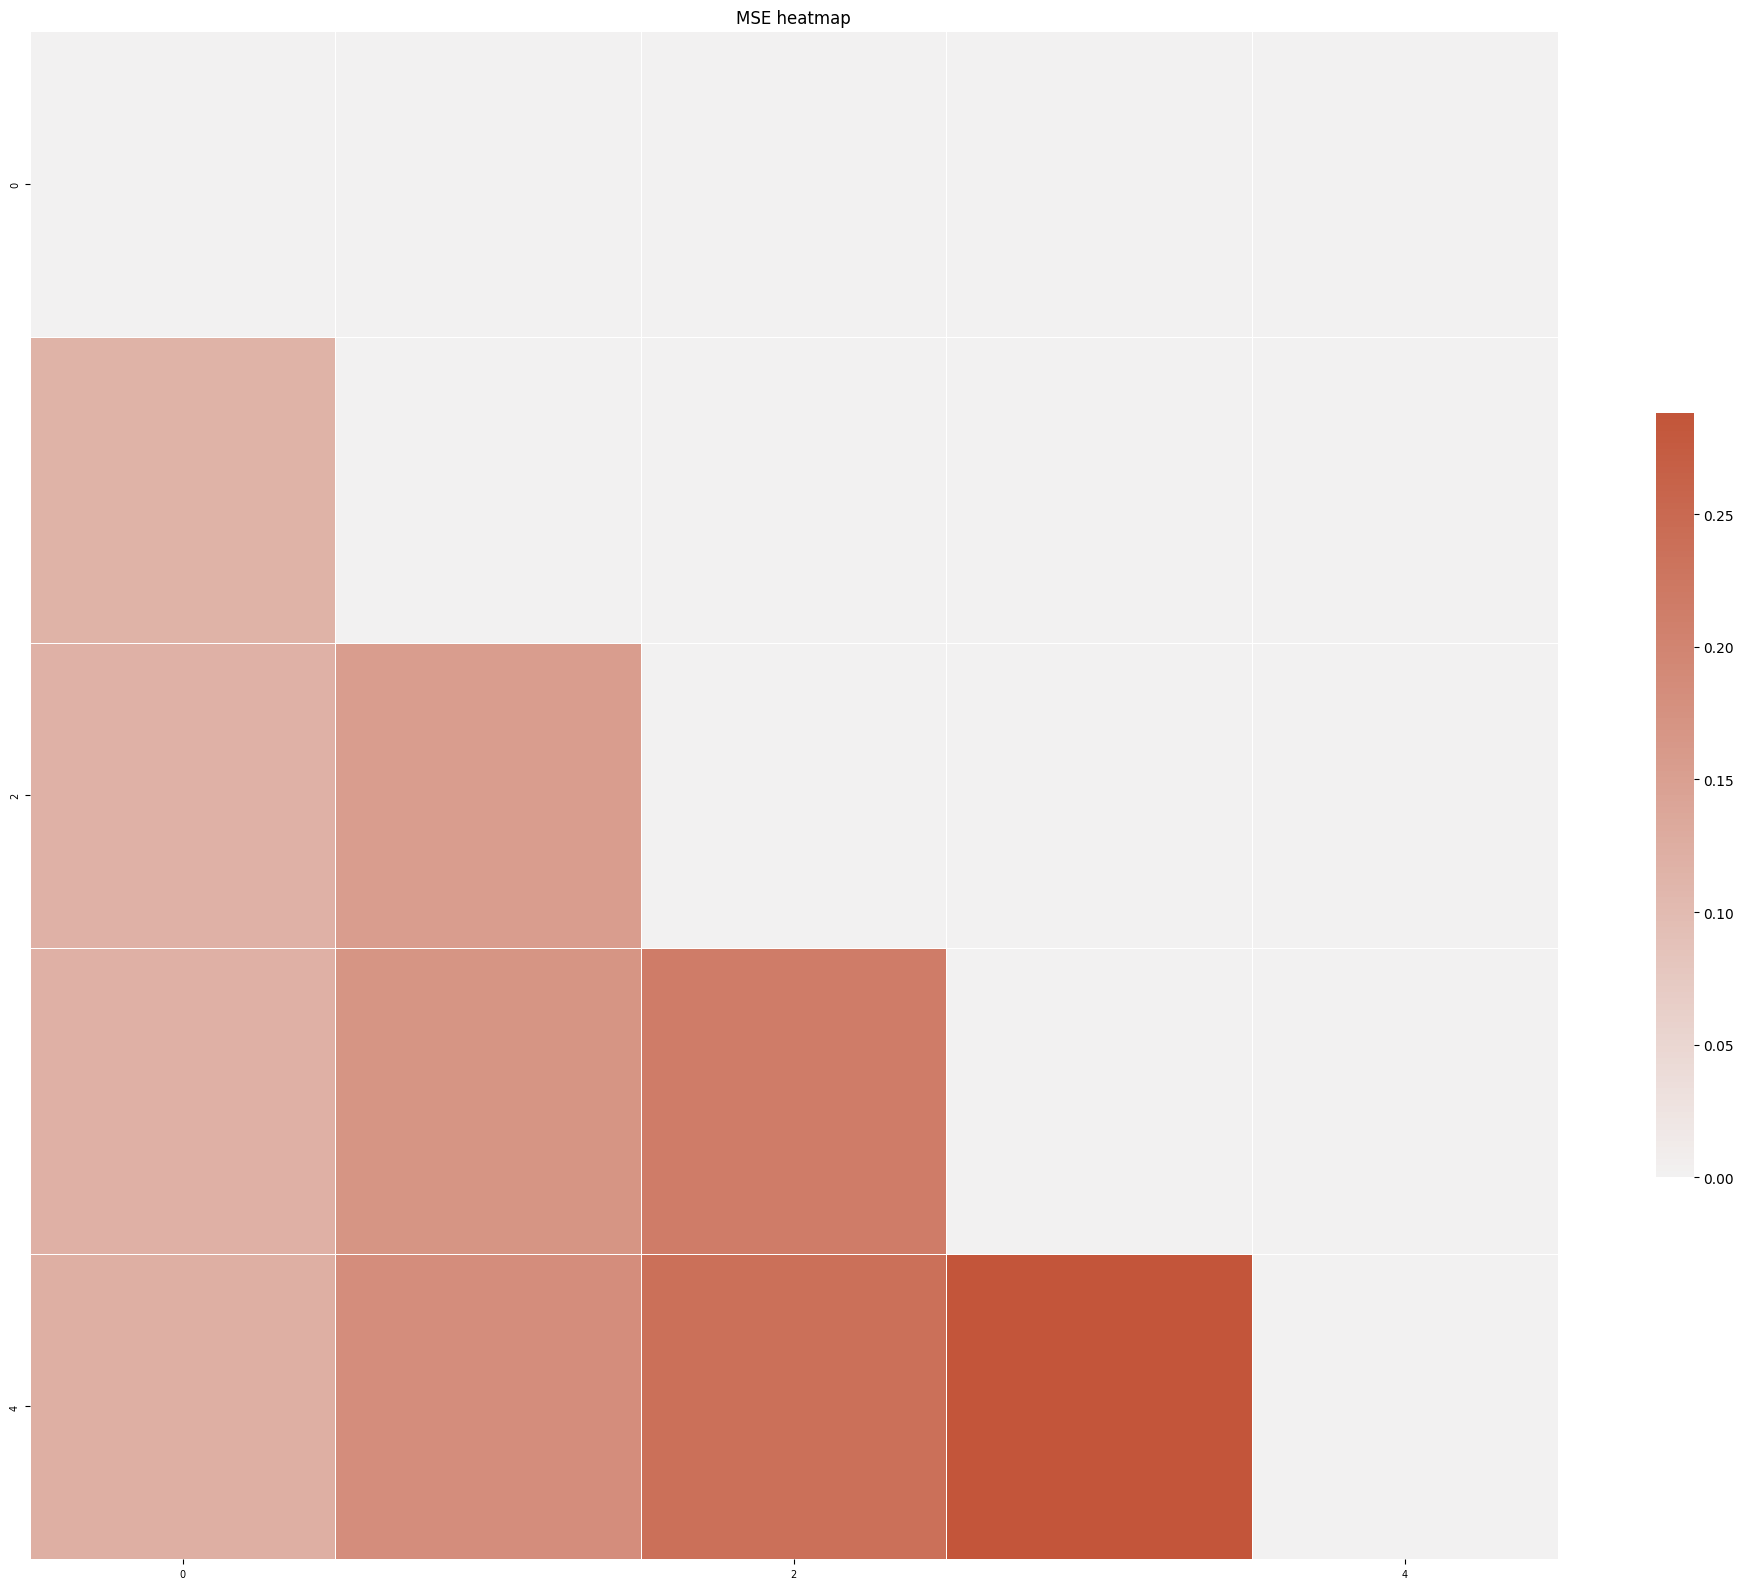

In [26]:
print(res_tuple[0])
print(res_tuple[1])
print(res_tuple[2])
# plot_heatmap(res_tuple[0], title = 'MSE heatmap', mask_ut = False)